In [1]:
import os
import pandas as pd
from torchvision.io import read_image
import random
from PIL import Image
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision.transforms as transforms
import numpy as np
import torchvision.models as models
from tqdm import tqdm
path = "/Users/liushiwen/Desktop/大四下/hw2/test_data"
path = "D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_train"
dir_list = os.listdir(path)

print(f"Files and directories in '{path}':")
# for item in dir_list:
#     print(item)


class CustomImageDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_files = [f for f in os.listdir(data_folder) if f.endswith(".png")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_folder, self.image_files[idx])
        image = read_image(image_path)
        image = image[0:3].float()
        # image = image.reshape(1, 128, 128)
        
        txt_file = os.path.splitext(self.image_files[idx])[0] + ".txt"
        txt_path = os.path.join(self.data_folder, txt_file)
        with open(txt_path, "r") as f:
            first_line = f.readline().strip()
            class_label = int(first_line.split()[0])

        if self.transform:
            image = self.transform(image)

        return image, class_label
    
def get_dataloaders(data_folder, transform, train_ratio, val_ratio, batch_size):
    # Create a single merged dataset
    train_dataset = CustomImageDataset(data_folder, transform)
    val_dataset = CustomImageDataset(data_folder, transform)
    test_dataset = CustomImageDataset(data_folder, transform)

    # obtain training indices that will be used for validation
    num_train = len(test_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)

    train_loader = DataLoader(merge_dataset, batch_size=batch_size)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size)
    test_loader = DataLoader(Subset(test_dataset, test_idx), batch_size=batch_size)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"Data Transform: {transform}")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders
transform = transforms.Compose([transforms.Resize((128, 128)),])
data_folder = path
custom_dataset = CustomImageDataset(data_folder, transform)
loaders = get_dataloaders(data_folder, transform, 1, 0.5, 1)


Files and directories in 'D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_train':
--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [87281, 83966, 15380, 88925, 78535]
--------- INDEX shuffled ---------

Total number of samples: 97396 datapoints
Number of train samples: 97396 batches/ 97396 datapoints
Number of val samples: 0 batches/ 0 datapoints
Number of test samples: 0 batches/ 0 datapoints
Data Transform: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
)



torch.Size([50, 1])


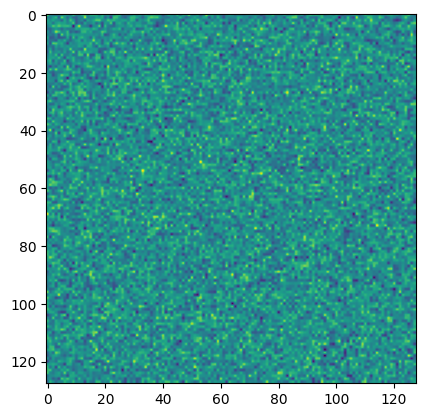

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
class ImageDownsizer(nn.Module):
    def __init__(self):
        super(ImageDownsizer, self).__init__()
        # Use Adaptive Average Pooling to reduce the image to 1x1
        self.downsize = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(in_features=1, out_features=1)
    
    def forward(self, x):
        x = self.downsize(x)
        # Flatten the output to get a single value per image in the batch
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

# Example usage:
model = ImageDownsizer()

# Assuming input images are grayscale with shape (batch_size, channels, height, width)
# Example input tensor with a batch size of 1, and 1 color channel (grayscale)
input_tensor = torch.randn(50, 1, 128, 128)
plt.imshow(input_tensor[0][0])
# Get the downsized output
output = model(input_tensor)
print(output.shape)  # Should print torch.Size([1, 1]), indicating 1 value in


In [3]:
import matplotlib.ticker as ticker
def analyze_pixel_distribution(dataloader):
    class_pixel_sums = {}
    
    # Iterate through the DataLoader
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            # Sum the pixel values of the current image
            pixel_sum = img.sum().item()
            
            # Append the pixel sum to the corresponding class entry in the dictionary
            if label.item() not in class_pixel_sums:
                class_pixel_sums[label.item()] = []
            class_pixel_sums[label.item()].append(pixel_sum)
    print('finished')
    # Plotting the distribution of pixel sums for each class
    fig, ax = plt.subplots()
    for class_label, pixel_sums in class_pixel_sums.items():
        if class_label == 0 or class_label == 1:
            ax.hist(pixel_sums, bins=60, alpha=0.5, label=f'Class {class_label}')
    
    ax.set_xlabel('Sum of pixel values')
    ax.set_ylabel('Frequency')
    ax.legend()

    # Setting smaller units and adding a grid
    ax.minorticks_on()  # Enable minor ticks
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=20)) # n=5 means 4 minor grid lines between major ticks
    # ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    
    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()



analyze_pixel_distribution(loaders['train'])


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

def analyze_and_compare_all_classes(dataloader):
    class_pixel_sums = {}

    # Iterate through the DataLoader
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            # Sum the pixel values of the current image
            pixel_sum = img.sum().item()

            # Append the pixel sum to the corresponding class entry in the dictionary
            if label.item() not in class_pixel_sums:
                class_pixel_sums[label.item()] = []
            class_pixel_sums[label.item()].append(pixel_sum)

    print('Finished gathering data.')

    # Determine the grid size for the subplot
    classes = sorted(class_pixel_sums.keys())
    num_comparisons = len(classes) * (len(classes) - 1) / 2
    grid_size = math.ceil(math.sqrt(num_comparisons))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(50, 50))  # Adjust figsize for higher resolution
    plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots
    subplot_count = 0

    for i in range(len(classes)):
        for j in range(i + 1, len(classes)):
            ax = axes[subplot_count // grid_size, subplot_count % grid_size]
            ax.hist(class_pixel_sums[classes[i]], bins=60, alpha=0.5, label=f'Class {classes[i]}')
            ax.hist(class_pixel_sums[classes[j]], bins=60, alpha=0.5, label=f'Class {classes[j]}')
            ax.set_title(f'{classes[i]} vs {classes[j]}')
            # Setting smaller units and adding a grid
            ax.minorticks_on()  # Enable minor ticks
            ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=20)) # n=5 means 4 minor grid lines between major ticks
            # ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
            
            ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
            ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
            
            ax.grid(True)
            ax.legend()
            subplot_count += 1

    # Hide unused subplots
    for k in range(subplot_count, grid_size * grid_size):
        axes[k // grid_size, k % grid_size].axis('off')

    # Save the combined plot
    plt.savefig('combined_class_comparisons(all).png', dpi=300)  # dpi parameter controls resolution
    plt.close()

# Example usage with your DataLoader:
analyze_and_compare_all_classes(loaders['train'])


Finished gathering data.


In [10]:
# threshold = 58000  # Adjust this based on your observation of pixel sums
# correct_predictions = 0
# total_images = 0
def thresholding(threshold):
    total_images = 0
    correct_predictions = 0
    for images, labels in tqdm(loaders['train']):
        pixel_sum = images.sum().item()
        
        # Predict class based on the sum
        if pixel_sum < threshold:
            predicted_class = 1
        else:
            # Randomly choose among classes 0 and 2-9
            # predicted_class = np.random.choice([0] + list(range(2, 10)))
            predicted_class = 0

        # Update accuracy tracking
        total_images += 1
        if predicted_class == labels.item():
            correct_predictions += 1

    # Calculate and print accuracy
    accuracy = correct_predictions / total_images
    print(f"Accuracy: {accuracy*100:.2f}%, threshold: {threshold}")
def thresholding_for0(threshold):
    total_images = 0
    correct_predictions = 0
    for images, labels in tqdm(loaders['train']):
        pixel_sum = images.sum().item()
        
        # Predict class based on the sum
        if pixel_sum > threshold:
            predicted_class = 0
        else:
            # Randomly choose among classes 0 and 2-9
            # predicted_class = np.random.choice([0] + list(range(2, 10)))
            predicted_class = 1

        # Update accuracy tracking
        total_images += 1
        if predicted_class == labels.item():
            correct_predictions += 1

    # Calculate and print accuracy
    accuracy = correct_predictions / total_images
    print(f"Accuracy: {accuracy*100:.2f}%, threshold: {threshold}")


    
def thresholding_2(threshold0, threshold1, other_class):
    total_images = 0
    correct_predictions = 0
    for images, labels in tqdm(loaders['train']):
        pixel_sum = images.sum().item()
        
        # Predict class based on the sum
        if pixel_sum > threshold0:
            predicted_class = 0
        elif pixel_sum < threshold1:
            predicted_class = 1
        
        else:
            # Randomly choose among classes 0 and 2-9
            # predicted_class = np.random.choice([0] + list(range(2, 10)))
            # predicted_class = np.random.choice(list(range(2, 10)))
            predicted_class = other_class # TEST 13:50

        # Update accuracy tracking
        total_images += 1
        if predicted_class == labels.item():
            correct_predictions += 1

    # Calculate and print accuracy
    accuracy = correct_predictions / total_images
    print(f"Accuracy: {accuracy*100:.2f}%, threshold: {threshold0}")
# thresholding_for0(110000)
# thresholding_for0(100000)
# thresholding_for0(90000)
# thresholding_for0(56000) 1548
# thresholding_for0(57000) 1556
# thresholding_for0(58000) 1564
# thresholding_for0(59000) 1569
# thresholding_for0(60000) 1573

# thresholding_for0(61000) 1577
# thresholding_for0(62000) 1582
# thresholding_for0(63000) 1587
# thresholding_for0(64000) 1589
# thresholding_for0(65000) 1592
# thresholding_for0(66000) 1595
# thresholding_for0(67000) 1593
# thresholding_for0(68000) 1594
# thresholding_for0(69000) 1595
    
# thresholding_2(67000, 65000) 1601
# thresholding_2(68000, 65500, 9) 1610
# thresholding_2(69000, 65500, 9) 1619
# thresholding_2(68000, 65000, 6) 1607
    

100%|██████████| 97396/97396 [01:52<00:00, 864.37it/s] 

Accuracy: 16.19%, threshold: 69000


In [51]:
sum = [0,0,0,0,0,
       0,0,0,0,0,]
for images, labels in tqdm(loaders['train']):
    sum[labels.item()]+=1


100%|██████████| 97396/97396 [00:45<00:00, 2143.05it/s]


In [59]:
all_sum = 0
for ii in range(10):
    print(f"{ii}: {sum[ii]}/ {sum[ii] *100 // 97396}%")
    # all_sum += sum[ii]
# print(all_sum)

0: 10785/ 11%
1: 10835/ 11%
2: 9531/ 9%
3: 9812/ 10%
4: 9314/ 9%
5: 8687/ 8%
6: 9474/ 9%
7: 10007/ 10%
8: 9427/ 9%
9: 9524/ 9%


In [47]:
threshold = 56000  # Adjust this based on your observation of pixel sums
correct_predictions = 0
total_images = 0

for images, labels in tqdm(loaders['train']):
    pixel_sum = images.sum().item()
    
    # Predict class based on the sum
    if pixel_sum < threshold:
        predicted_class = 1
    else:
        # Randomly choose among classes 0 and 2-9
        predicted_class = np.random.choice([0] + list(range(2, 10)))

    # Update accuracy tracking
    if labels.item() == 1:
        total_images += 1
        if predicted_class == labels.item():
            correct_predictions += 1

# Calculate and print accuracy
accuracy = correct_predictions / total_images
print(f"Accuracy: {accuracy*100:.2f}%")

100%|██████████| 9739/9739 [00:06<00:00, 1578.96it/s]

Accuracy: 41.24%


In [9]:
def count_parameters(model):
    total_num = 0
    for parameter in model.parameters():
        if parameter.requires_grad:
            total_num += parameter.numel() 
    return total_num


In [20]:
from datetime import datetime

def pprint(output = '\n', show_time = False): # print and fprint at the same time
    filename = "hw2-1-2-MAR24.txt"
    print(output)
    with open(filename, 'a') as f:
        if show_time:
            f.write(datetime.now().strftime("[%Y-%m-%d %H:%M:%S] "))

        f.write(str(output))
        f.write('\n')
pprint("OFFICIAL START, Focus on the 2nd problem", True)

OFFICIAL START, Focus on the 2nd problem


In [24]:
import torch
# 69000 4000 1620
# weight: 69500.0, gap: -4000, acc: 16.22%
# weight: 70000.0, gap: -4000, acc: 16.23%
# weight: 70000.0, gap: -4000, acc: 20.41% gap1low: 80000
# weight: 70000.0, gap: -4000, acc: 20.61% gap1low: 70000
# 140000 210000 -> 1
# 150000 210000 -> 1
# 210000 310000 -> 7

def custom_optimizer(model, data_loader,model_name, num_candidates=1):
    best_weight = None
    best_accuracy = 0.16

    # Generate three candidate weights
    # candidate_weights = [torch.FloatTensor(1).uniform_(*candidate_range) for _ in range(num_candidates)]

    # candidate_weights = [torch.tensor(0.485), torch.tensor(0.2), torch.tensor(0.01)]
    # candidate_weights = [torch.rand(1) * (40000 - 50000) + 70000 for _ in range (num_candidates)]
    # candidate_weights = [torch.tensor(40000.) for _ in range (num_candidates)]
    original_weight = torch.tensor(70000.)

    for ii in range(num_candidates):
        # Temporarily set the model's parameter to the candidate weight
        weight = original_weight - ii * 500
        model.single_param.data = weight

        correct = 0
        total = 0
        # gap = -4000
        # gap1low = 70000
        # gap1high = 140000
        # gap7high = 240000

        print(f"")
        # Evaluate the model with the candidate weight
        model.eval()
        with torch.no_grad():
            for inputs, labels in tqdm(data_loader):
                # print(inputs.sum().item())
                outputs = model(inputs)
                # # print(outputs)
                # # _, predicted = torch.max(outputs.data, 1)
                # # predicted = (outputs.data > 0).long()
                # predicted = torch.empty_like(outputs.data, dtype=torch.long)
                # predicted[outputs.data > gap7high] = 0
                # predicted[(outputs.data <= gap7high) & (outputs.data > gap1high)] = 7
                # predicted[(outputs.data <= gap1high) & (outputs.data > gap1low)] = 1
                # predicted[(outputs.data <= gap1low) & (outputs.data > 0)] = 0

                # # Assign class 9 to elements where outputs.data is between -4000 and 0
                # predicted[(outputs.data > gap) & (outputs.data <= 0)] = 9

                # # Assign class 1 to all other elements (i.e., outputs.data <= -4000)
                # predicted[outputs.data <= gap] = 1
                # print(outputs.data)
                # print(outputs)
                total += labels.size(0)
                correct += (outputs == labels).sum().item()
                # break
        accuracy = correct / total
        print(f"weight: {weight}, acc: {accuracy*100:.2f}%")
        # Check if this candidate is the best so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_weight = weight
            print(f"best accuracy: {accuracy*100:.2f}%")

        # Restore the original weight
        model.single_param.data = original_weight

    # Update the model parameter to the best candidate weight
    model.single_param.data = best_weight
    # print(f"The best: {best_weight}")
    model_scripted = torch.jit.script(model) # Export to TorchScript
    model_scripted.save(f'{model_name}.pt') # Save
    print(f"weight saved as: {model_name}.pt")
# Assuming `model` is your OneParaModel instance and `data_loader` is your DataLoader instance
custom_optimizer(model, loaders['train'], "OneParaModel")


100%|██████████| 97396/97396 [01:30<00:00, 1076.90it/s]


weight: 70000.0, acc: 20.61%
best accuracy: 20.61%


RuntimeError: 
range cannot be used as a tuple:
  File "C:\Users\User\AppData\Local\Temp\ipykernel_26540\3621978674.py", line 8
        # # batch_mean = x.mean(dim=[1, 2, 3], keepdim=True) // 255
        # sum_per_batch_item = input_tensor.sum(dim=tuple(range(1, input_tensor.dim())), keepdim=True) / 255 / 2 / 2
        sum_per_batch_item = x.sum(dim=tuple(range(1, x.dim())), keepdim=True)
                                       ~~~~~~~~~~~~~~~~~~~~ <--- HERE
        output = sum_per_batch_item - self.single_param
        gap = -4000


In [72]:
def train(model, model_name):
    pprint(f"Training model: {model_name}", True)
    model_parameters_amount = count_parameters(model)
    iteration = 0
    pprint(f"Total parameters: {model_parameters_amount:,}")
    for images, labels in tqdm(loaders['train']):
        output = model(images)
        print(output)
        # pixel_sum = images.sum().item()

        # # Predict class based on the sum
        # if pixel_sum < threshold:
        #     predicted_class = 1
        # else:
        #     # Randomly choose among classes 0 and 2-9
        #     predicted_class = np.random.choice([0] + list(range(2, 10)))

        # # Update accuracy tracking
        # if labels.item() == 1:
        #     total_images += 1
        #     if predicted_class == labels.item():
        #         correct_predictions += 1
        iteration +=1
        if iteration > 3:
            break
    # Calculate and print accuracy
    # accuracy = correct_predictions / total_images
    # print(f"Accuracy: {accuracy*100:.2f}%")

In [52]:
class OneParaModel_mean(nn.Module):
    def __init__(self):
        super(OneParaModel_mean, self).__init__()
        self.single_param = nn.Parameter(torch.tensor(70000.))
    def forward(self, x):
        batch_size = x.size(0)
        
        # Collapse all dimensions except the batch into one
        # This transforms x from shape [batch_size, ...] to [batch_size, -1]
        x_collapsed = x.view(batch_size, -1)
        
        # Now perform the sum over the collapsed dimension
        sum_per_batch_item = x_collapsed.sum(dim=1, keepdim=True)

        output = sum_per_batch_item - self.single_param
        gap = -4000
        gap1low = 70000
        gap1high = 140000
        gap7high = 240000

        # Initialize the tensor for predicted classes
        predicted = torch.empty_like(output, dtype=torch.long)

        # Apply the thresholding rules to assign class predictions
        predicted[output > gap7high] = 0
        predicted[(output <= gap7high) & (output > gap1high)] = 7
        predicted[(output <= gap1high) & (output > gap1low)] = 1
        predicted[(output <= gap1low) & (output > 0)] = 0
        predicted[(output > gap) & (output <= 0)] = 9
        predicted[output <= gap] = 1

        return predicted.squeeze()
    
    
model = OneParaModel_mean()
model_name = "OneParaModel"
print(next(model.parameters()))
# train(model, model_name)
# input_tensor = torch.randn(2, 1, 2, 2)
input_tensor = torch.tensor([[[0,255],[255,255]]])
print(input_tensor)
output = model(input_tensor)
print(output)

Parameter containing:
tensor(70000., requires_grad=True)
tensor([[[  0, 255],
         [255, 255]]])
tensor(1)


In [32]:
# torch.save(model.state_dict(), f'{model_name}.pth')

In [53]:

model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(f'{model_name}.pt') # Save
print(f"weight saved as: {model_name}.pt")

weight saved as: OneParaModel.pt


In [41]:
model.state_dict()

OrderedDict([('single_param', tensor(70000.))])

In [55]:

    
model2 = torch.jit.load(f'D:\\Casper\\aML\\HW2\\OneParaModel.pt')

def evaluation(model, data_loader):

    correct = 0
    total = 0

    print(f"")
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            outputs = model(inputs)
            total += labels.size(0)
            correct += (outputs == labels).sum().item()
    accuracy = correct / total
    print(f"Total accuracy: {accuracy*100:.2f}%")
evaluation(model2, loaders['train'])
    

100%|██████████| 97396/97396 [01:31<00:00, 1066.88it/s]

Total accuracy: 20.61%


In [56]:
def count_parameters(model):
    total_num = 0
    for parameter in model.parameters():
        if parameter.requires_grad:
            total_num += parameter.numel() 
    return total_num


In [57]:
count_parameters(model2)ㄑ


1

In [64]:
from torchvision import models
from torchsummary import summary
import inspect
# print(model2.forward)
print(inspect.getsource(model2.forward))

TypeError: module, class, method, function, traceback, frame, or code object was expected, got ScriptMethod